**Imports and function definitions**

In [1]:
import os
from glob import glob
from natsort import natsorted
from nimlab import connectomics as cs
from nimlab.connectomics import ConnectomeSubject
from nimlab.jax_functions import load_image, NiftiMasker
import numpy as np
from tqdm import tqdm

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

def create_connectome_subjects(cs_roi, cs_brain, roi_list, masker_list, roi_connectome_type, brain_connectome_type, same_connectome, warning_flag):
    # Load paths to all ROI connectome files
    roi_connectome_files_norms = natsorted(glob(os.path.join(cs_roi, "*_norms.npy")))
    roi_connectome_files = [
        (glob(f.split("_norms")[0] + ".npy")[0], f) for f in roi_connectome_files_norms
    ]

    # Load paths to all Brain connectome files
    brain_connectome_files_norms = natsorted(glob(os.path.join(cs_brain, "*_norms.npy")))
    brain_connectome_files = [
        (glob(f.split("_norms")[0] + ".npy")[0], f)
        for f in brain_connectome_files_norms
    ]

    # Create ConnectomeSubject objects
    subjects = []
    for roi_connectome_file, brain_connectome_file in zip(roi_connectome_files, brain_connectome_files):
        subject = ConnectomeSubject(
            roi_connectome_file,
            brain_connectome_file,
            roi_list,
            roi_connectome_type,
            brain_connectome_type,
            same_connectome,
            warning_flag
        )
        subjects.append(subject)
    
    return subjects


Save BOLD signal in the brain ROI as numpy arrays (probably won't be very useful, but just in case)

In [16]:
cs_roi = '/data/nimlab/connectome_npy/GSP1000_MF'
cs_brain = '/data/nimlab/connectome_npy/GSP1000_MF'
masker_list = [] 
roi_connectome_type = 'volume'
brain_connectome_type = 'volume'
same_connectome = False
warning_flag = True
roi_list = {
    # 1:np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_csf_brainstem_roi.nii.gz')),
    # 2:np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_masked_brainstem_roi.nii.gz')),
    3:np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_dil_brainstem_roi.nii.gz')),
} 

subjects = create_connectome_subjects(cs_roi, cs_brain, roi_list, masker_list, roi_connectome_type, brain_connectome_type, same_connectome, warning_flag)

if not os.path.exists('bold_signal/GSP1000_MF_bold_brainstem_masked_240.npy'):

    results_120 = []
    results_240 = []
    for i, sub in enumerate(tqdm(subjects, desc="Processing subjects")):
        result = cs.extract_avg_signal(
            connectome_mat=np.load(sub.brain_connectome_file),
            roi_mat=np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_masked_brainstem_roi.nii.gz')),
        )
        if result.shape == (240,):
            results_240.append(result)
        if result.shape == (120,):
            results_120.append(result)

    results_240 = np.array(results_240)
    results_120 = np.array(results_120)

    np.save('bold_signal/GSP1000_MF_bold_brainstem_masked_240.npy', results_240)
    np.save('bold_signal/GSP1000_MF_bold_brainstem_masked_120.npy', results_120)




**Make the Yeo1000 bold signal**

In [2]:
cs_roi = '/data/nimlab/connectome_npy/yeo1000_dil'
cs_brain = '/data/nimlab/connectome_npy/yeo1000_dil'
masker_list = [] 
roi_connectome_type = 'volume'
brain_connectome_type = 'volume'
same_connectome = False
warning_flag = True
roi_list = {
    # 1:np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_csf_brainstem_roi.nii.gz')),
    2:np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_masked_brainstem_roi.nii.gz')),
    # 3:np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_dil_brainstem_roi.nii.gz')),
} 

subjects = create_connectome_subjects(cs_roi, cs_brain, roi_list, masker_list, roi_connectome_type, brain_connectome_type, same_connectome, warning_flag)

if not os.path.exists('bold_signal/yeo1000_dil_bold_brainstem_masked_240.npy'):

    results_120 = []
    results_240 = []
    for i, sub in enumerate(tqdm(subjects, desc="Processing subjects")):
        result = cs.extract_avg_signal(
            connectome_mat=np.load(sub.brain_connectome_file),
            roi_mat=np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/1-r_01_gsp1000MF_vs_yeo1000_masked_brainstem_roi.nii.gz')),
        )
        if result.shape == (240,):
            results_240.append(result)
        if result.shape == (120,):
            results_120.append(result)

    results_240 = np.array(results_240)
    results_120 = np.array(results_120)

    np.save('bold_signal/yeo1000_dil_bold_brainstem_masked_240.npy', results_240)
    np.save('bold_signal/yeo1000_dil_bold_brainstem_masked_120.npy', results_120)




Processing subjects: 100%|██████████| 1000/1000 [11:56<00:00,  1.40it/s]


Create a correlation matrix with ROIs and some csf masks for GSP1000_MF

In [4]:
cs_roi_gsp1000mf = '/data/nimlab/connectome_npy/GSP1000_MF'
cs_brain_gsp1000mf = '/data/nimlab/connectome_npy/GSP1000_MF'
masker_list = [] 
roi_connectome_type = 'volume'
brain_connectome_type = 'volume'
same_connectome = False
warning_flag = True


roi_list = {
    'posterior_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/posterior_csf_mask_2mm.nii.gz')),
    'lateral_ventrical_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/lateral_ventricular_csf_mask_2mm.nii.gz')),
    'inferomedial_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/inferomedial_csf_mask_2mm.nii.gz')),
    'brainstem_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/brainstem_csf_mask_2mm.nii.gz')),
    'overall_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/csf_mask_2mm.nii.gz')),
    'mrt':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/MRT_bilateral.nii.gz')),
    'vsm':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/VSM_bilateral.nii.gz')),
    'sphere_random_1':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-26_-62_-64.nii.gz')),
    'sphere_random_2':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-18_-72_-56.nii.gz')),
    'sphere_random_3':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-28_-78_-52.nii.gz')),
    'sphere_random_4':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-2_-46_-52.nii.gz')),
} 

subjects_gsp1000_mf = create_connectome_subjects(cs_roi_gsp1000mf, cs_brain_gsp1000mf, roi_list, masker_list, roi_connectome_type, brain_connectome_type, same_connectome, warning_flag)

result_gsp1000_mf = cs.calculate_roi_matrix(
    subjects=subjects_gsp1000_mf,
    num_workers=4
)


/PHShome/jt041/joseph_env/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [03:49<00:00,  4.37it/s]
/PHShome/jt041/joseph_env/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1048: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


Plot GSP1000_MF correlation matrix

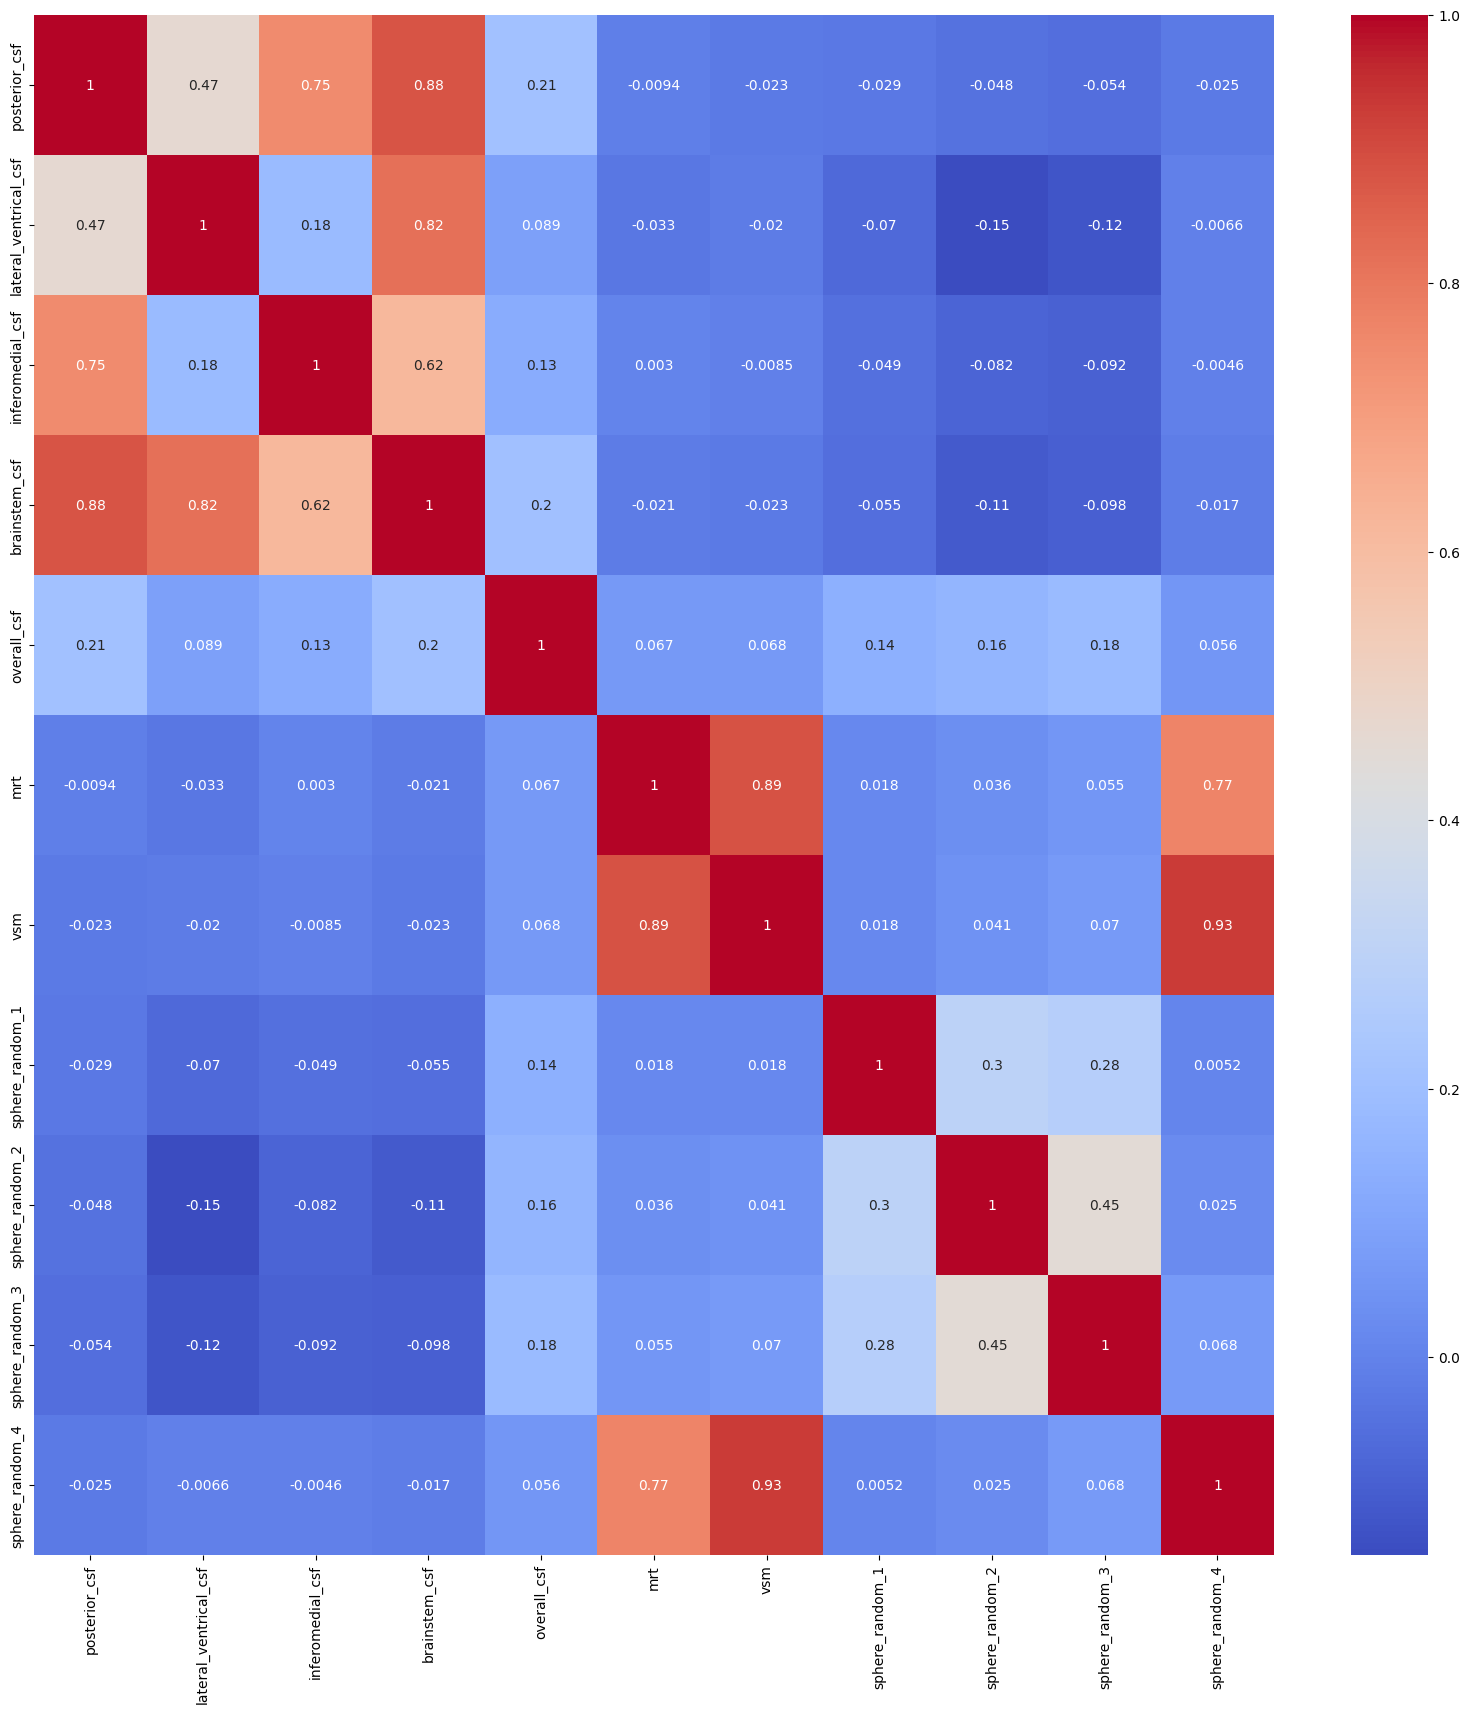

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(result_gsp1000_mf[1], xticklabels=result_gsp1000_mf[-1], yticklabels=result_gsp1000_mf[-1], cmap='coolwarm', annot=True)
plt.show()


**Now, make the same correlation matrix, but using Yeo1000**

In [19]:
cs_roi_yeo1000 = '/data/nimlab/connectome_npy/yeo1000_dil'
cs_brain_yeo1000 = '/data/nimlab/connectome_npy/yeo1000_dil'
masker_list = [] 
roi_connectome_type = 'volume'
brain_connectome_type = 'volume'
same_connectome = False
warning_flag = True


roi_list = {
    'posterior_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/posterior_csf_mask_2mm.nii.gz')),
    'lateral_ventrical_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/lateral_ventricular_csf_mask_2mm.nii.gz')),
    'inferomedial_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/inferomedial_csf_mask_2mm.nii.gz')),
    'brainstem_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/brainstem_csf_mask_2mm.nii.gz')),
    'overall_csf':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/masks/csf_mask_2mm.nii.gz')),
    'mrt':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/MRT_bilateral.nii.gz')),
    'vsm':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/VSM_bilateral.nii.gz')),
    'sphere_random_1':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-26_-62_-64.nii.gz')),
    'sphere_random_2':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-18_-72_-56.nii.gz')),
    'sphere_random_3':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-28_-78_-52.nii.gz')),
    'sphere_random_4':np.atleast_2d(NiftiMasker().transform('/PHShome/jt041/projects/connectome_differences/rois/sphere_-2_-46_-52.nii.gz')),
} 

subjects_yeo1000 = create_connectome_subjects(cs_roi_yeo1000, cs_brain_yeo1000, roi_list, masker_list, roi_connectome_type, brain_connectome_type, same_connectome, warning_flag)

result_yeo1000 = cs.calculate_roi_matrix(
    subjects=subjects_yeo1000,
    num_workers=4
)


/PHShome/jt041/joseph_env/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]
/PHShome/jt041/joseph_env/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1048: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


**Plot the Yeo1000 correlation matrix**

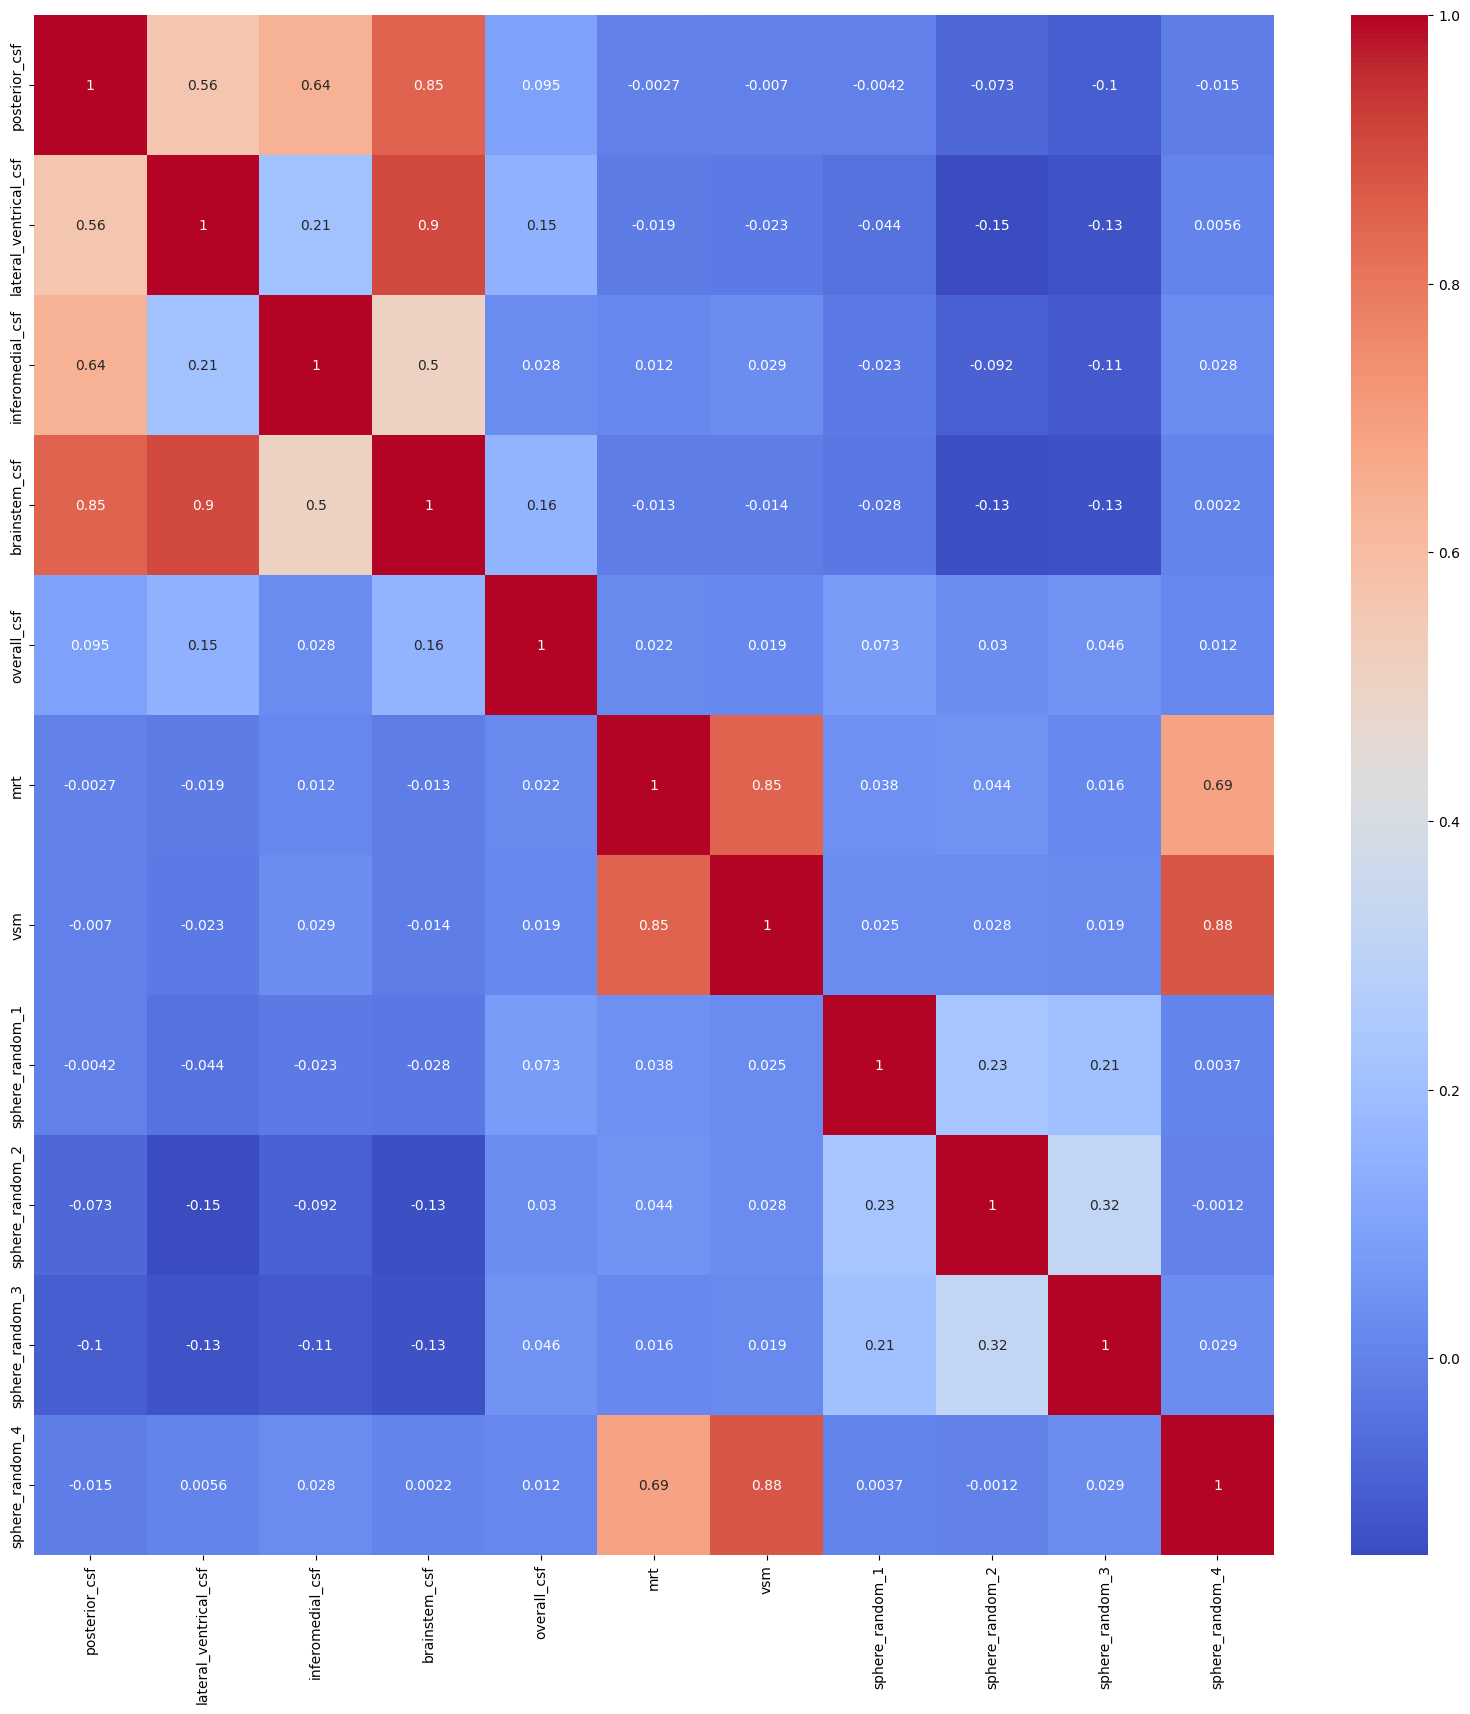

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(result_yeo1000[1], xticklabels=result_yeo1000[-1], yticklabels=result_yeo1000[-1], cmap='coolwarm', annot=True)
plt.show()

**Now, plot the difference matrix; higher values indicate correlations that were higher in GSP1000_MF, lower values indicate correlations that were higher in Yeo1000**

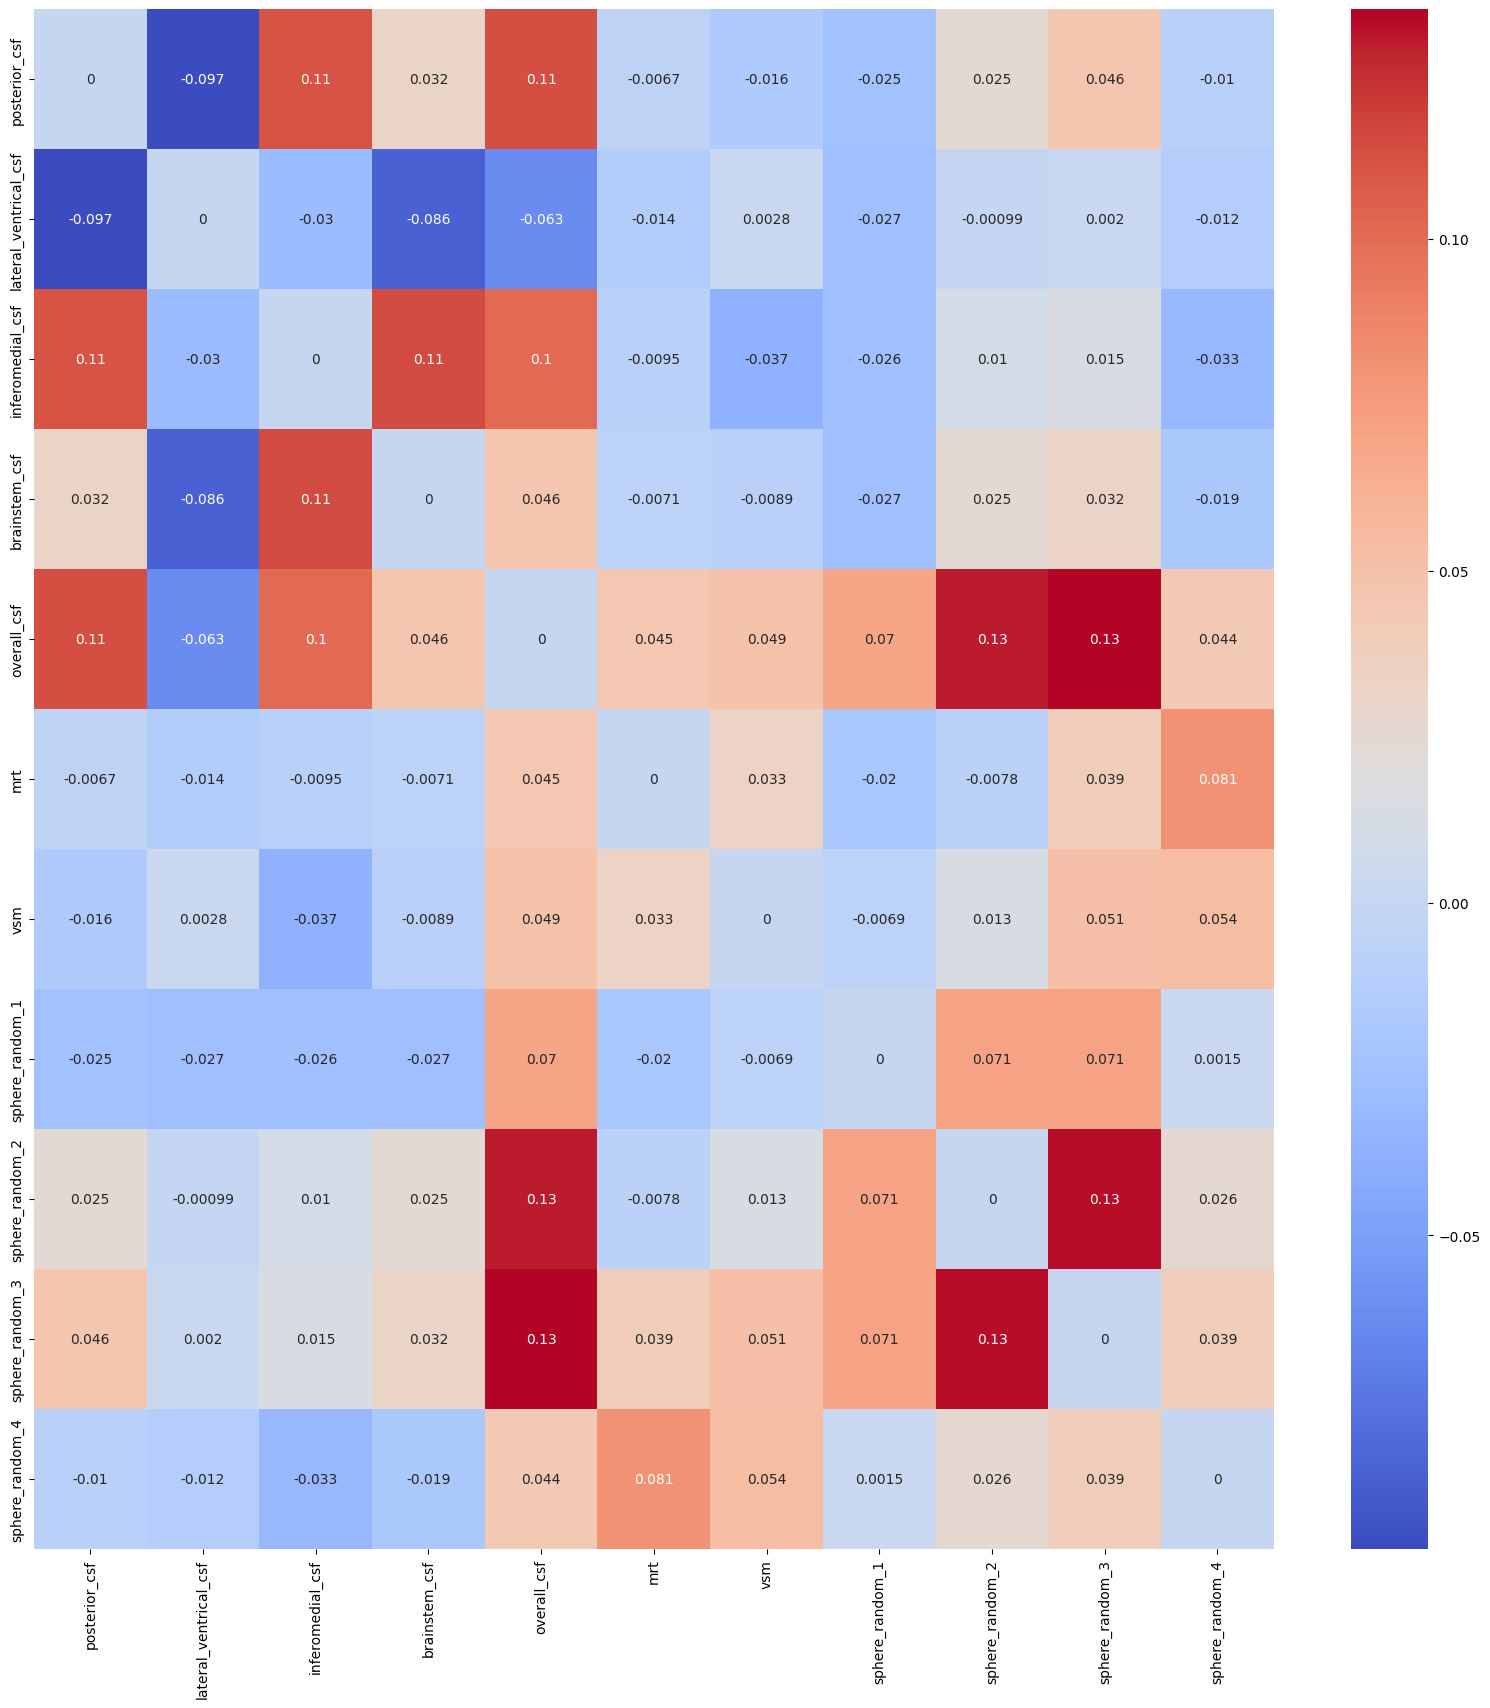

In [21]:
difference_matrix = result_gsp1000_mf[1] - result_yeo1000[1]

plt.figure(figsize=(20, 20))
sns.heatmap(difference_matrix, xticklabels=result_yeo1000[-1], yticklabels=result_yeo1000[-1], cmap='coolwarm', annot=True)
plt.show()


**It looks like the GSP1000_MF is a little more connected to CSF signals, especially the overall_csf signal, but its not very clear what's going on.**

**Let's do a similar analysis, but using 20 random CSF spheres and 20 random medulla/cerebellum spheres**

In [24]:
import os
import pandas as pd
import numpy as np

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

df_medulla_cerebellum_spheres = pd.read_csv('/PHShome/jt041/projects/connectome_differences/csvs/sphere_coords.csv')
df_medulla_cerebellum_spheres = df_medulla_cerebellum_spheres[df_medulla_cerebellum_spheres['region_type'] == 'brain']
df_medulla_cerebellum_spheres = df_medulla_cerebellum_spheres[df_medulla_cerebellum_spheres['mni_coord'].str.len() > 0]
df_csf_spheres = pd.read_csv('/PHShome/jt041/projects/connectome_differences/csvs/csf_sphere_coords.csv')

cs_roi_gsp1000mf = '/data/nimlab/connectome_npy/GSP1000_MF'
cs_brain_gsp1000mf = '/data/nimlab/connectome_npy/GSP1000_MF'
masker_list = [] 
roi_connectome_type = 'volume'
brain_connectome_type = 'volume'
same_connectome = False
warning_flag = True

roi_list = {}
for i, row in df_medulla_cerebellum_spheres.iterrows():
    roi_list[f'medulla_cerebellum_sphere_{i}'] = np.atleast_2d(NiftiMasker().transform(row['sphere_path']))
    
# Do the same for the csf spheres
for i, row in df_csf_spheres.iterrows():
    roi_list[f'csf_sphere_{i}'] = np.atleast_2d(NiftiMasker().transform(row['sphere_path']))

roi_list

subjects_gsp1000_mf = create_connectome_subjects(cs_roi_gsp1000mf, cs_brain_gsp1000mf, roi_list, masker_list, roi_connectome_type, brain_connectome_type, same_connectome, warning_flag)

result_gsp1000_mf = cs.calculate_roi_matrix(
    subjects=subjects_gsp1000_mf,
    num_workers=4
)

/PHShome/jt041/joseph_env/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/PHShome/jt041/joseph_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/PHShome/jt041/joseph_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/PHShome/jt041/joseph_env/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]
/PHShome/jt041/joseph_env/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1048: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


**Plot this correlation matrix**

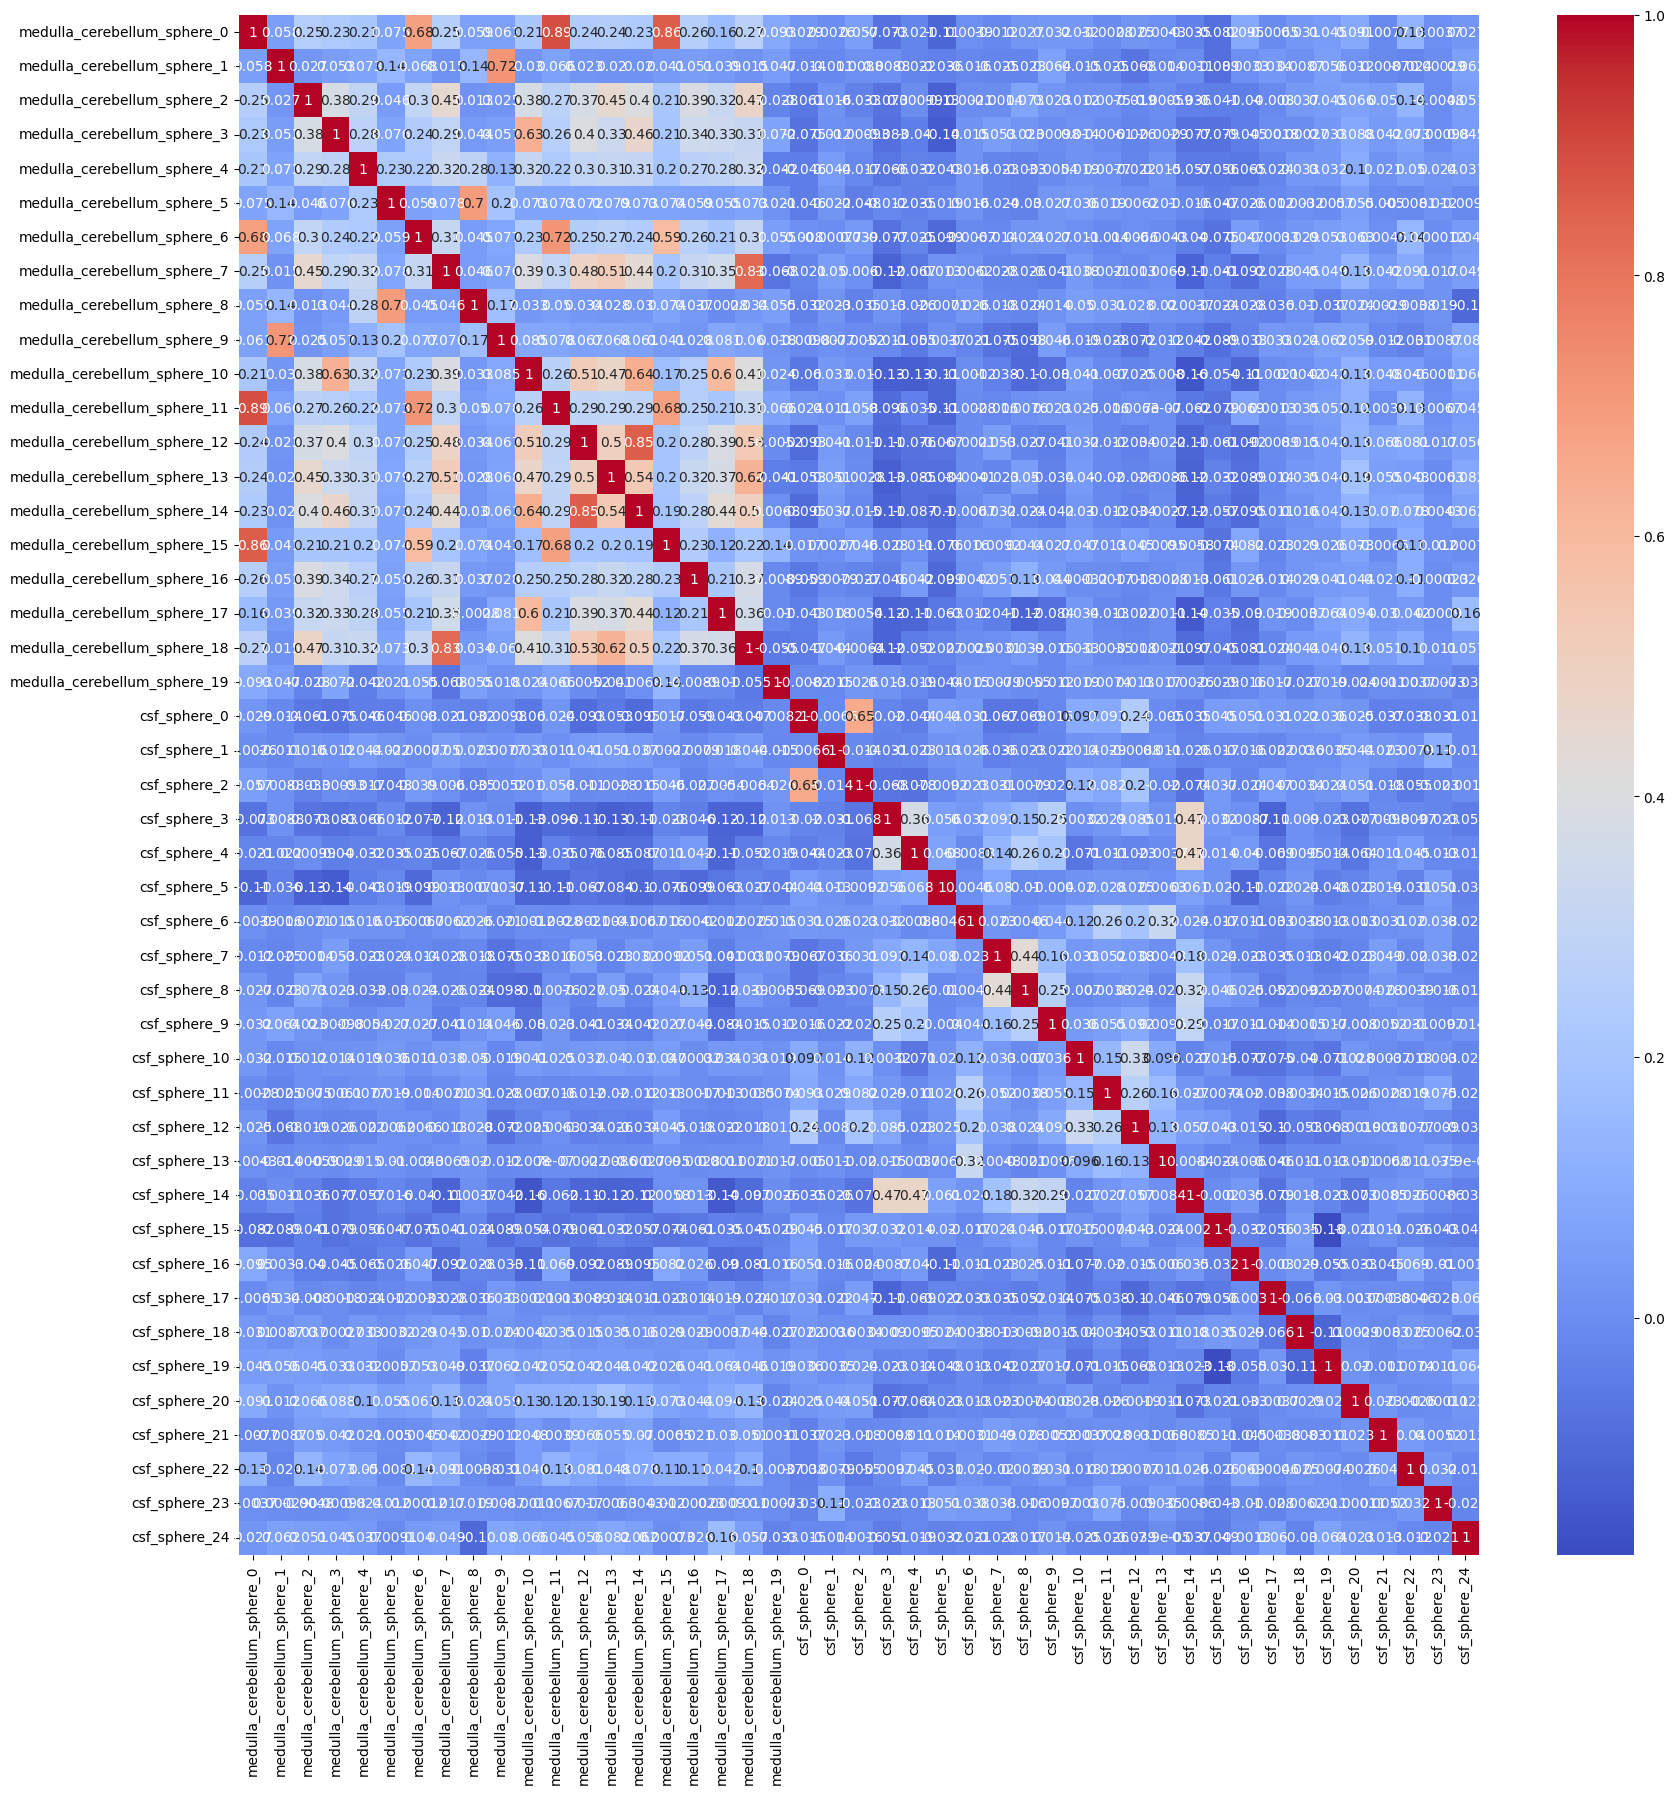

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(result_gsp1000_mf[1], xticklabels=result_gsp1000_mf[-1], yticklabels=result_gsp1000_mf[-1], cmap='coolwarm', annot=True)
plt.show()

**Now, make the same correlation matrix, but using Yeo1000**

In [26]:
import os
import pandas as pd
import numpy as np

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

df_medulla_cerebellum_spheres = pd.read_csv('/PHShome/jt041/projects/connectome_differences/csvs/sphere_coords.csv')
df_medulla_cerebellum_spheres = df_medulla_cerebellum_spheres[df_medulla_cerebellum_spheres['region_type'] == 'brain']
df_medulla_cerebellum_spheres = df_medulla_cerebellum_spheres[df_medulla_cerebellum_spheres['mni_coord'].str.len() > 0]
df_csf_spheres = pd.read_csv('/PHShome/jt041/projects/connectome_differences/csvs/csf_sphere_coords.csv')

cs_roi_yeo1000 = '/data/nimlab/connectome_npy/yeo1000_dil'
cs_brain_yeo1000 = '/data/nimlab/connectome_npy/yeo1000_dil'
masker_list = [] 
roi_connectome_type = 'volume'
brain_connectome_type = 'volume'
same_connectome = False
warning_flag = True

roi_list = {}
for i, row in df_medulla_cerebellum_spheres.iterrows():
    roi_list[f'medulla_cerebellum_sphere_{i}'] = np.atleast_2d(NiftiMasker().transform(row['sphere_path']))
    
# Do the same for the csf spheres
for i, row in df_csf_spheres.iterrows():
    roi_list[f'csf_sphere_{i}'] = np.atleast_2d(NiftiMasker().transform(row['sphere_path']))

roi_list

subjects_yeo1000 = create_connectome_subjects(cs_roi_yeo1000, cs_brain_yeo1000, roi_list, masker_list, roi_connectome_type, brain_connectome_type, same_connectome, warning_flag)

result_yeo1000 = cs.calculate_roi_matrix(
    subjects=subjects_yeo1000,
    num_workers=4
)


/PHShome/jt041/joseph_env/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 42%|████▏     | 424/1000 [01:10<01:40,  5.76it/s]/PHShome/jt041/joseph_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
 42%|████▎     | 425/1000 [01:11<01:52,  5.11it/s]/PHShome/jt041/joseph_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
100%|██████████| 1000/1000 [02:56<00:00,  5.66it/s]
/PHShome/jt041/joseph_env/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1048: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


**Plot the Yeo1000 correlation matrix**

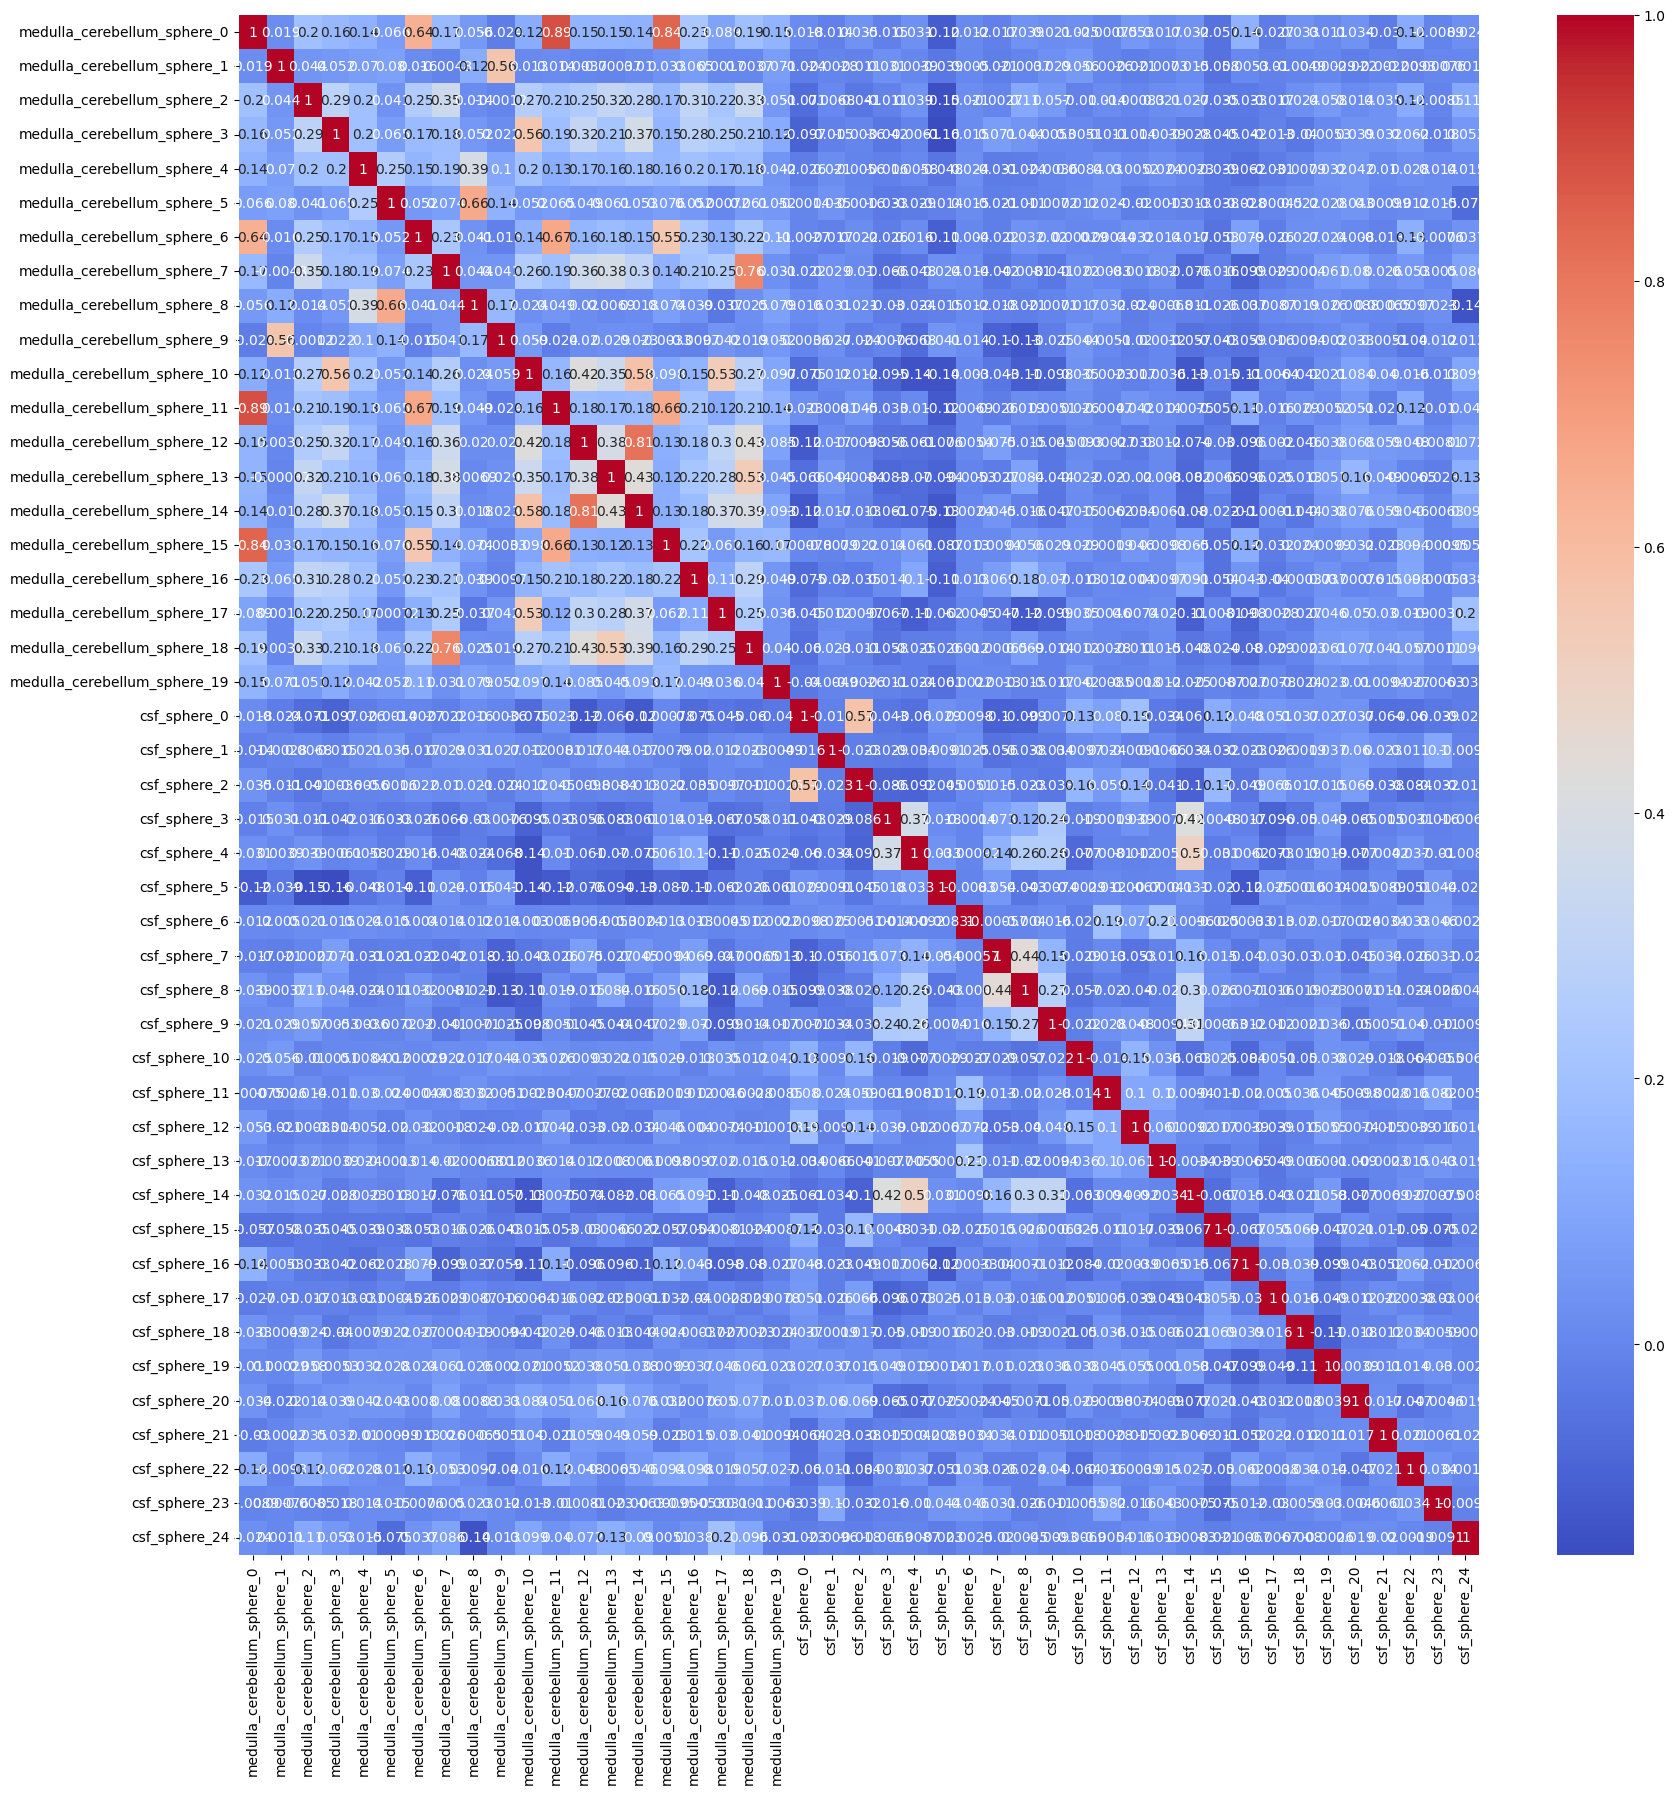

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(result_yeo1000[1], xticklabels=result_yeo1000[-1], yticklabels=result_yeo1000[-1], cmap='coolwarm', annot=True)
plt.show()

**Plot the difference matrix**

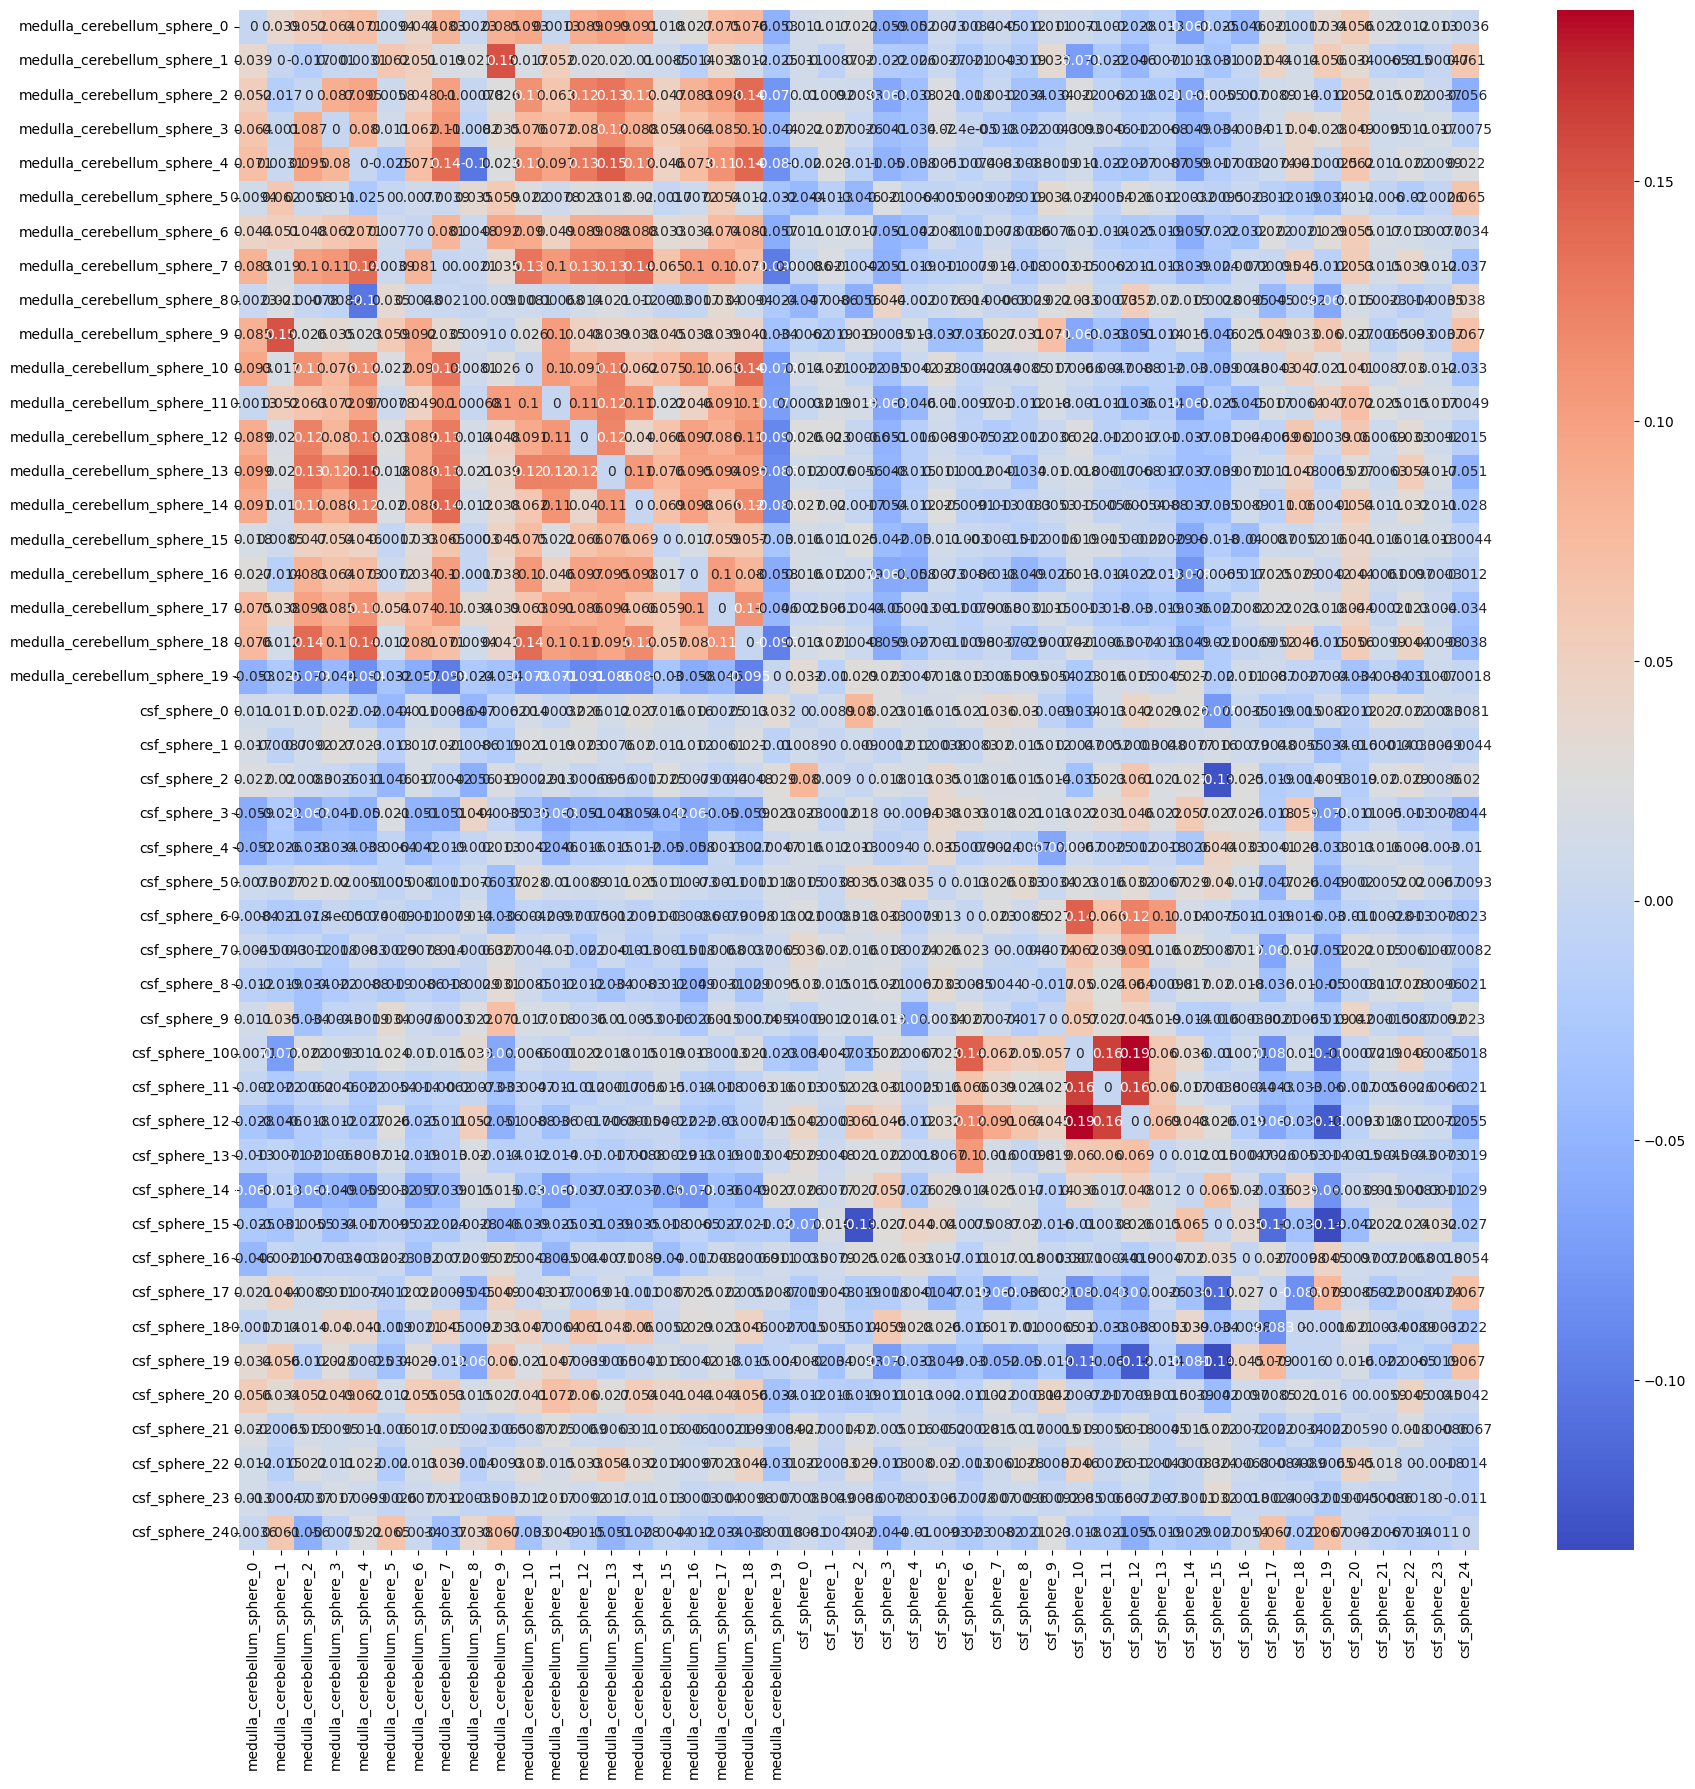

In [28]:

difference_matrix = result_gsp1000_mf[1] - result_yeo1000[1]    

plt.figure(figsize=(20, 20))
sns.heatmap(difference_matrix, xticklabels=result_yeo1000[-1], yticklabels=result_yeo1000[-1], cmap='coolwarm', annot=True)
plt.show()

**Now, I want to pull out all correlations between csf_spheres and medulla_cerebellum_spheres (without redundancy)**

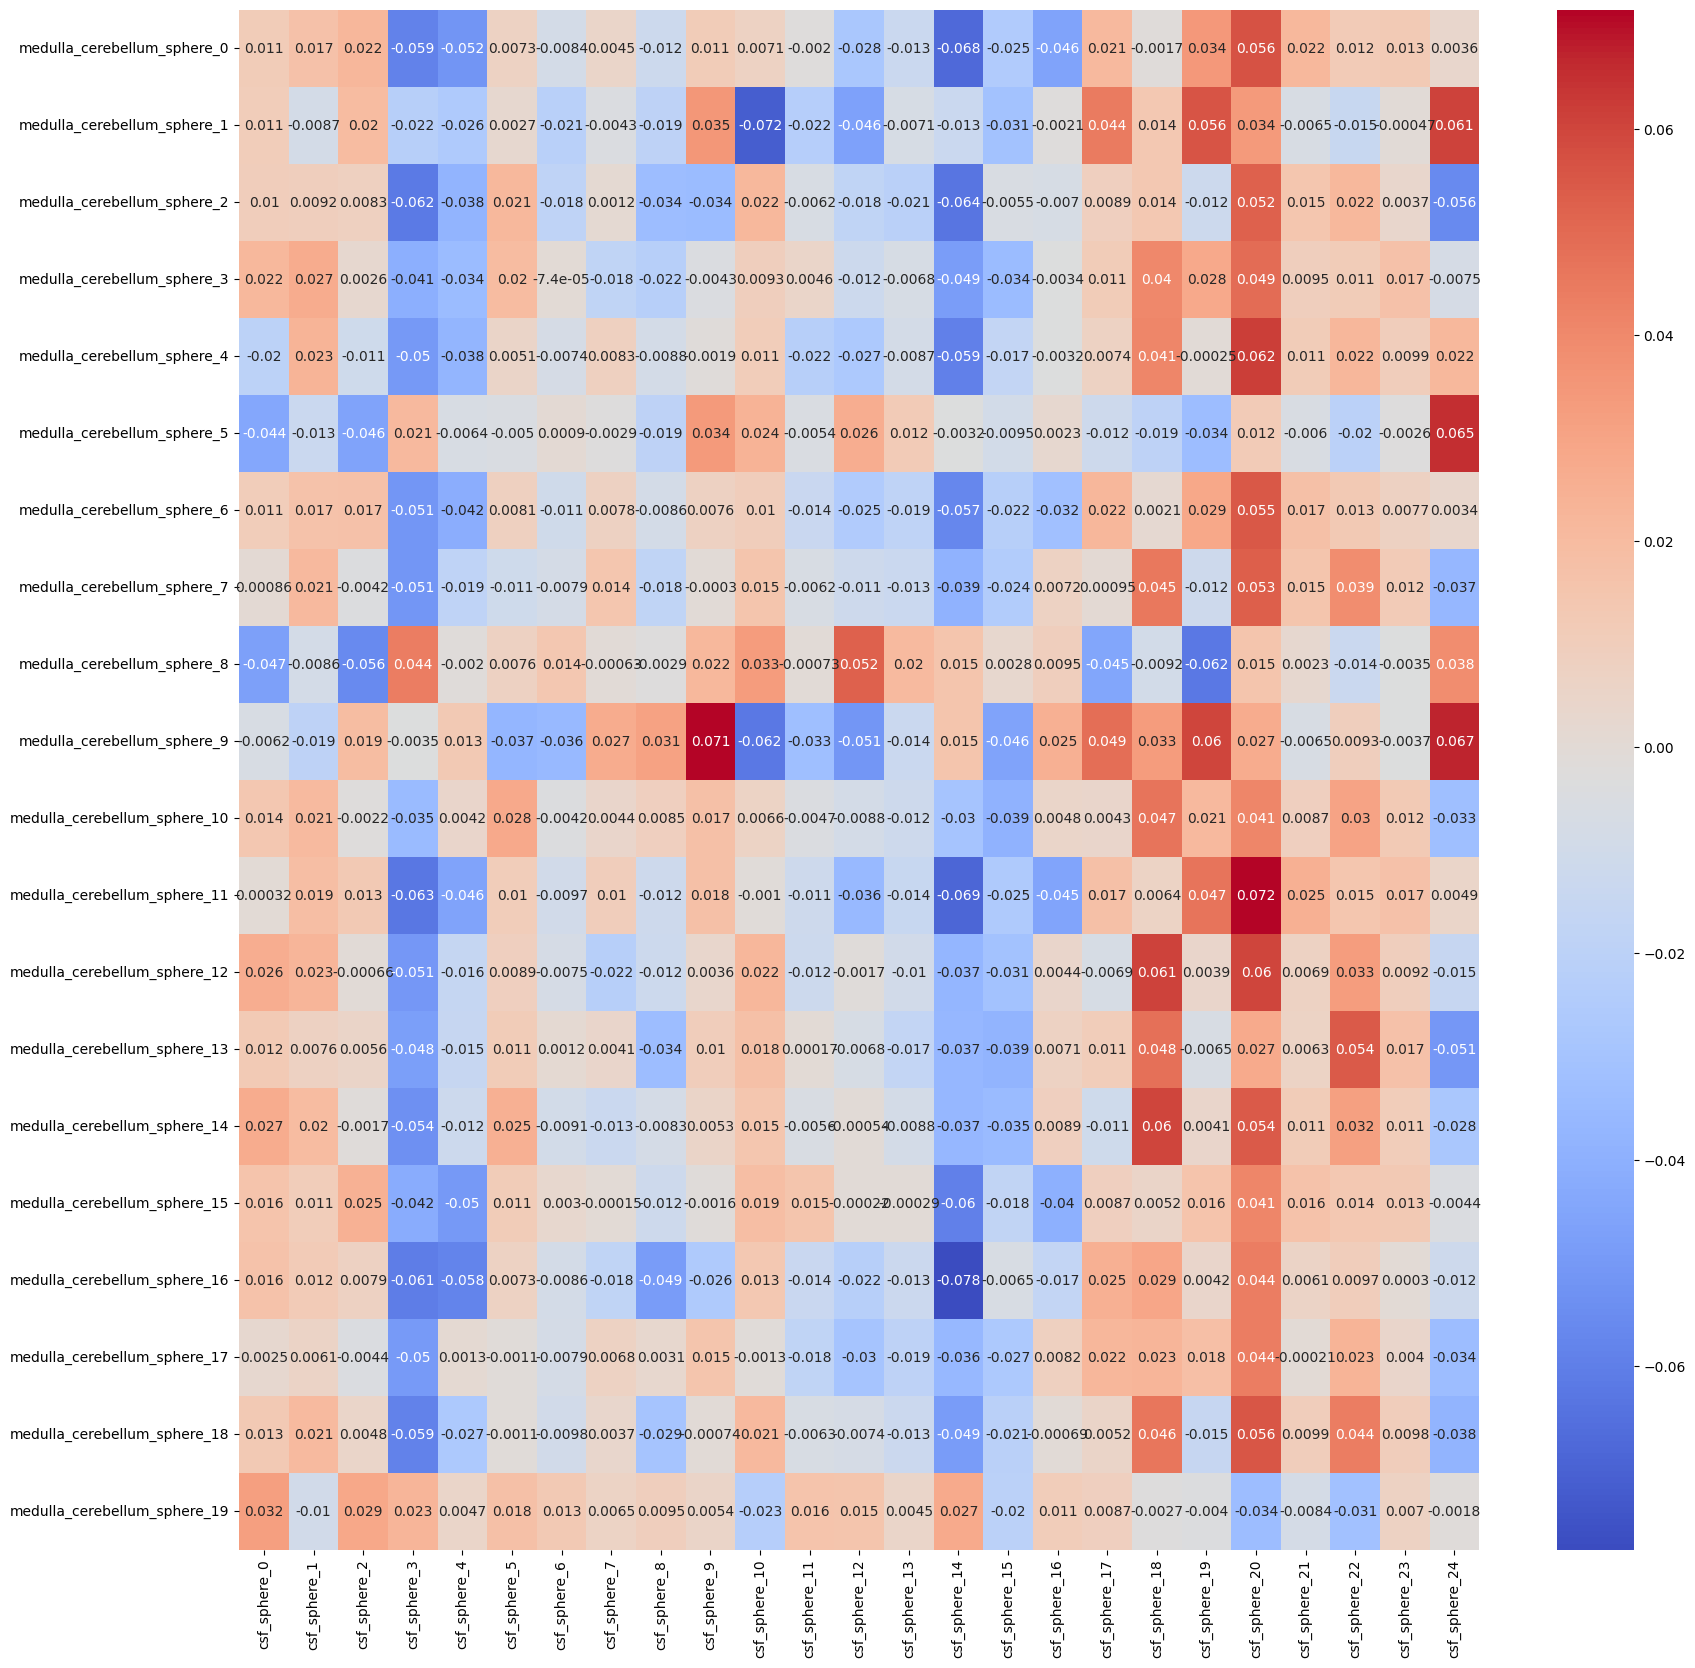

In [44]:
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

"""
**Now, I want to pull out all correlations between csf_spheres and medulla_cerebellum_spheres (without redundancy)**
"""   

difference_matrix # Has all the correlations between the spheres
result_yeo1000[-1] # Has the labels of the spheres
difference_matrix.shape # (45, 45)
list(result_yeo1000[-1])[0]
result_yeo1000[-1]

# Let's plot just this subset. 
difference_matrix[:20,20:]

plt.figure(figsize=(20, 20))
sns.heatmap(difference_matrix[:20,20:], xticklabels=list(result_yeo1000[-1])[20:], yticklabels=list(result_yeo1000[-1])[:20], cmap='coolwarm', annot=True)
plt.show()


In [47]:

"Let's do a two-sample t-test comparing result_gsp1000_mf[1][:20,20:] and result_yeo1000[1][:20,20:]"

from scipy.stats import ttest_ind

gsp1000_mf_values = result_gsp1000_mf[1][:20,20:].flatten()
yeo1000_values = result_yeo1000[1][:20,20:].flatten()

ttest_ind(gsp1000_mf_values, yeo1000_values)


TtestResult(statistic=-0.25616494902928344, pvalue=0.7978762640910068, df=998.0)

**Let's compare random voxel pairings between medulla and lateral ventricles in GSP1000_MF and Yeo1000**

In [25]:
from nimlab.jax_functions import NiftiMasker, load_image
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm
from scipy.stats import ttest_rel

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

def fetch_precomputed_data(x, y, z, connectome='gsp1000_mf'):
    if z <= 2:
        return None
    gsp_1000_mf_precomputed_path = '/data/nimlab/precomputed_connectomes/GSP1000_MF'
    yeo1000_dil_precomputed_path = '/data/nimlab/precomputed_connectomes/yeo1000_dil'
    path_prefix = gsp_1000_mf_precomputed_path if connectome == 'gsp1000_mf' else yeo1000_dil_precomputed_path
    voxel_string = f'{x}_{y}_{z}'
    suffix = "_AvgR_Fz.nii.gz"
    full_path = os.path.join(path_prefix, f'{voxel_string}{suffix}')
    return load_image(full_path).get_fdata()

def fetch_voxel_connectivity(roi1_path, roi2_path, roi1_data=None, roi2_data=None):
    if roi1_data is None:
        roi1_data = load_image(roi1_path).get_fdata()
    if roi2_data is None:
        roi2_data = load_image(roi2_path).get_fdata()

    # Randomly select an index where the value is 1 in roi1
    roi1_indices = np.argwhere(roi1_data == 1)
    roi1_index = roi1_indices[np.random.choice(roi1_indices.shape[0])]

    # Fetch the precomputed data seeded at this index in roi1
    try:
        roi1_connectivity_map_gsp = fetch_precomputed_data(*roi1_index, connectome='gsp1000_mf')
        roi1_connectivity_map_yeo = fetch_precomputed_data(*roi1_index, connectome='yeo1000_dil')
    except:
        return None, None, None, None
    if roi1_connectivity_map_gsp is None or roi1_connectivity_map_yeo is None:
        return None, None, None, None

    # Randomly select a non-zero index from roi2
    roi2_indices = np.argwhere(roi2_data == 1)
    roi2_index = roi2_indices[np.random.choice(roi2_indices.shape[0])]

    # Find the value in the roi1_connectivity_map at the roi2_index
    connectivity_value_gsp = roi1_connectivity_map_gsp[roi2_index[0], roi2_index[1], roi2_index[2]]
    connectivity_value_yeo = roi1_connectivity_map_yeo[roi2_index[0], roi2_index[1], roi2_index[2]]

    voxel_idx_1 = roi1_index
    voxel_idx_2 = roi2_index

    return voxel_idx_1, voxel_idx_2, connectivity_value_gsp, connectivity_value_yeo


medulla_roi_path = "rois/1-r_01_gsp1000MF_vs_yeo1000_masked_brainstem_roi.nii.gz"
medulla_roi_data = load_image(medulla_roi_path).get_fdata()

left_lateral_ventricle_path = 'masks/left_lateral_ventricle_mask_2mm.nii.gz'
right_lateral_ventricle_path = 'masks/right_lateral_ventricle_mask_2mm.nii.gz'

left_lateral_ventricle_data = load_image(left_lateral_ventricle_path).get_fdata()
right_lateral_ventricle_data = load_image(right_lateral_ventricle_path).get_fdata()
lateral_ventricle_data = np.logical_or(left_lateral_ventricle_data, right_lateral_ventricle_data)

df_list = []

for i in tqdm(range(5000)):
    voxel_idx_1, voxel_idx_2, connectivity_value_gsp, connectivity_value_yeo = fetch_voxel_connectivity(medulla_roi_path, left_lateral_ventricle_path, roi1_data=medulla_roi_data, roi2_data=lateral_ventricle_data)
    if connectivity_value_gsp is not None:
        df_list.append({
            'roi1': 'medulla',
            'roi2': 'lateral_ventricle',
            'voxel_idx_1': voxel_idx_1,
            'voxel_idx_2': voxel_idx_2,
            'gsp1000_mf_AvgR': connectivity_value_gsp,
            'yeo1000_dil_AvgR': connectivity_value_yeo,
            'diff': connectivity_value_gsp - connectivity_value_yeo
        })

df = pd.concat([pd.DataFrame([entry]) for entry in df_list], ignore_index=True)

# Let's do a paired t-test for the difference in connectivity between the two connectomes, without regard to region.
t, p = ttest_rel(df['gsp1000_mf_AvgR'], df['yeo1000_dil_AvgR'])
print(f"t={t:.2f}, p={p:.3f}")

df.to_csv('csvs/medulla_lateral_ventricle_connectivity_global.csv', index=False)
df


100%|██████████| 5000/5000 [07:33<00:00, 11.02it/s]


t=5.09, p=0.000


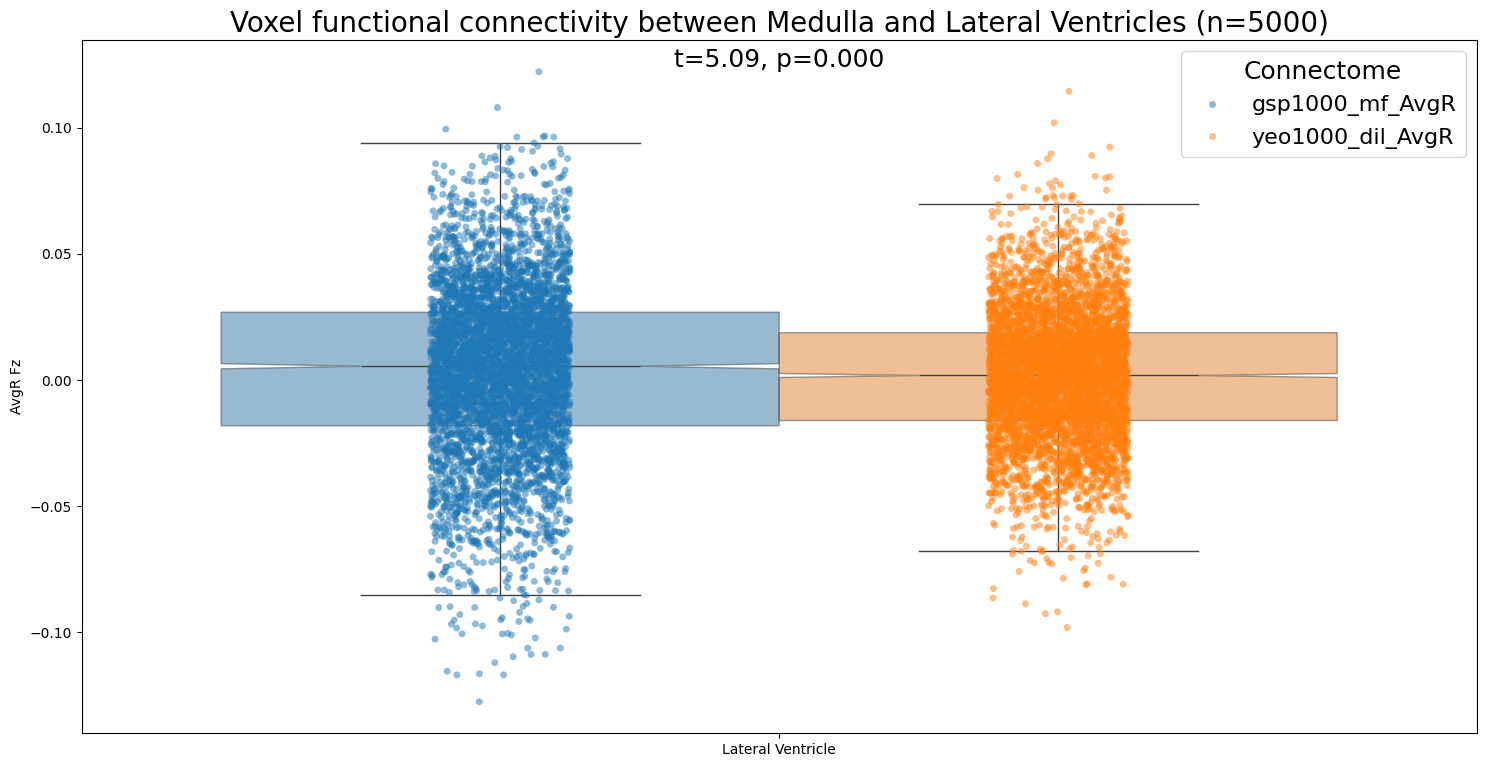

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('medulla_lateral_ventricle_connectivity_global.csv')

# Melt the dataframe for plotting
df_melted = pd.melt(df, id_vars=['roi1', 'roi2', 'diff'],
                    value_vars=['gsp1000_mf_AvgR', 'yeo1000_dil_AvgR'],
                    var_name='connectome', value_name='AvgR')

plt.figure(figsize=(18, 9))
sns.stripplot(data=df_melted, x='roi2', y='AvgR', hue='connectome', dodge=True, jitter=True, alpha=0.5)
sns.boxplot(data=df_melted, x='roi2', y='AvgR', hue='connectome', dodge=True, 
            boxprops=dict(alpha=0.5), showfliers=False, notch=True)

# Add the p-values to the plot at appropriate positions
# Get the y-position for the labels
y_max_ant = df_melted['AvgR'].max()
# y_max_post = df_melted[df_melted['roi2'] == 'posterior']['AvgR'].max()

plt.text(0, y_max_ant, f"t={t:.2f}, p={p:.3f}", ha='center', va='bottom', fontsize=18, color='black')
# plt.text(0.75, y_max_post, f"t={t_post:.2f}, p={p_post:.3f}", ha='center', va='bottom', fontsize=18, color='black')

plt.title('Voxel functional connectivity between Medulla and Lateral Ventricles (n=5000)', fontsize=20)
plt.xlabel('')
plt.xticks([0], ['Lateral Ventricle'])
plt.ylabel('AvgR Fz')
# For the legend, we don't need to show the legend for the stripplot, just the boxplot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Connectome', fontsize=16, title_fontsize=18)
plt.savefig('figures/medulla_lateral_ventricle_connectivity.png', transparent=True)
plt.show()


In [2]:
from nimlab.jax_functions import NiftiMasker, load_image
import os
import numpy as np
import pandas as pd 
from tqdm import tqdm
from scipy.stats import ttest_rel

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

def fetch_precomputed_data(x, y, z, connectome='gsp1000_mf'):
    if z <= 2:
        return None
    gsp_1000_mf_precomputed_path = '/data/nimlab/precomputed_connectomes/GSP1000_MF'
    yeo1000_dil_precomputed_path = '/data/nimlab/precomputed_connectomes/yeo1000_dil'
    path_prefix = gsp_1000_mf_precomputed_path if connectome == 'gsp1000_mf' else yeo1000_dil_precomputed_path
    voxel_string = f'{x}_{y}_{z}'
    suffix = "_AvgR_Fz.nii.gz"
    full_path = os.path.join(path_prefix, f'{voxel_string}{suffix}')
    return load_image(full_path).get_fdata()

def fetch_voxel_connectivity(roi1_path, roi2_path, roi1_data=None, roi2_data=None):
    if roi1_data is None:
        roi1_data = load_image(roi1_path).get_fdata()
    if roi2_data is None:
        roi2_data = load_image(roi2_path).get_fdata()

    # Randomly select an index where the value is 1 in roi1
    roi1_indices = np.argwhere(roi1_data == 1)
    roi1_index = roi1_indices[np.random.choice(roi1_indices.shape[0])]

    # Fetch the precomputed data seeded at this index in roi1
    try:
        roi1_connectivity_map_gsp = fetch_precomputed_data(*roi1_index, connectome='gsp1000_mf')
        roi1_connectivity_map_yeo = fetch_precomputed_data(*roi1_index, connectome='yeo1000_dil')
    except:
        return None, None, None, None
    if roi1_connectivity_map_gsp is None or roi1_connectivity_map_yeo is None:
        return None, None, None, None

    # Randomly select a non-zero index from roi2
    roi2_indices = np.argwhere(roi2_data == 1)
    roi2_index = roi2_indices[np.random.choice(roi2_indices.shape[0])]

    # Find the value in the roi1_connectivity_map at the roi2_index
    connectivity_value_gsp = roi1_connectivity_map_gsp[roi2_index[0], roi2_index[1], roi2_index[2]]
    connectivity_value_yeo = roi1_connectivity_map_yeo[roi2_index[0], roi2_index[1], roi2_index[2]]

    voxel_idx_1 = roi1_index
    voxel_idx_2 = roi2_index

    return voxel_idx_1, voxel_idx_2, connectivity_value_gsp, connectivity_value_yeo


medulla_roi_path = "rois/1-r_01_gsp1000MF_vs_yeo1000_masked_brainstem_roi.nii.gz"
medulla_roi_data = load_image(medulla_roi_path).get_fdata()

csf_path = 'masks/csf_mask_2mm.nii.gz'

csf_data = load_image(csf_path).get_fdata()

df_list = []

for i in tqdm(range(5000)):
    voxel_idx_1, voxel_idx_2, connectivity_value_gsp, connectivity_value_yeo = fetch_voxel_connectivity(medulla_roi_path, csf_path, roi1_data=medulla_roi_data, roi2_data=csf_data)
    if connectivity_value_gsp is not None:
        df_list.append({
            'roi1': 'medulla',
            'roi2': 'csf',
            'voxel_idx_1': voxel_idx_1,
            'voxel_idx_2': voxel_idx_2,
            'gsp1000_mf_AvgR': connectivity_value_gsp,
            'yeo1000_dil_AvgR': connectivity_value_yeo,
            'diff': connectivity_value_gsp - connectivity_value_yeo
        })

df = pd.concat([pd.DataFrame([entry]) for entry in df_list], ignore_index=True)

# Let's do a paired t-test for the difference in connectivity between the two connectomes, without regard to region.
t, p = ttest_rel(df['gsp1000_mf_AvgR'], df['yeo1000_dil_AvgR'])
print(f"t={t:.2f}, p={p:.3f}")

df.to_csv('csvs/medulla_csf_connectivity_global.csv', index=False)
df


100%|██████████| 5000/5000 [12:00<00:00,  6.94it/s]


t=14.65, p=0.000


roi1 roi2   voxel_idx_1   voxel_idx_2  gsp1000_mf_AvgR  \
0     medulla  csf  [43, 26, 13]  [62, 92, 50]         0.083655   
1     medulla  csf  [49, 27, 10]  [46, 68, 41]        -0.015723   
2     medulla  csf  [43, 22, 17]  [45, 38, 53]         0.016794   
3     medulla  csf   [62, 36, 6]  [75, 29, 31]         0.089883   
4     medulla  csf   [35, 34, 8]  [12, 67, 39]         0.038752   
...       ...  ...           ...           ...              ...   
4828  medulla  csf   [35, 32, 6]  [31, 98, 38]         0.037614   
4829  medulla  csf   [53, 26, 8]  [57, 50, 74]        -0.028832   
4830  medulla  csf   [40, 38, 7]  [50, 57, 21]        -0.011104   
4831  medulla  csf   [30, 28, 7]  [18, 37, 12]         0.101851   
4832  medulla  csf  [47, 31, 10]  [15, 43, 21]        -0.023688   

      yeo1000_dil_AvgR      diff  
0             0.044282  0.039373  
1            -0.031034  0.015310  
2             0.033014 -0.016220  
3             0.059450  0.030433  
4             0.062992 -0.024240  
...                ...       ...  
4828         -0.002111  0.039724  
4829         -0.021350 -0.007482  
4830          0.004460 -0.015564  
4831          0.056681  0.045170  
4832         -0.018064 -0.005625  

[4833 rows x 7 columns]

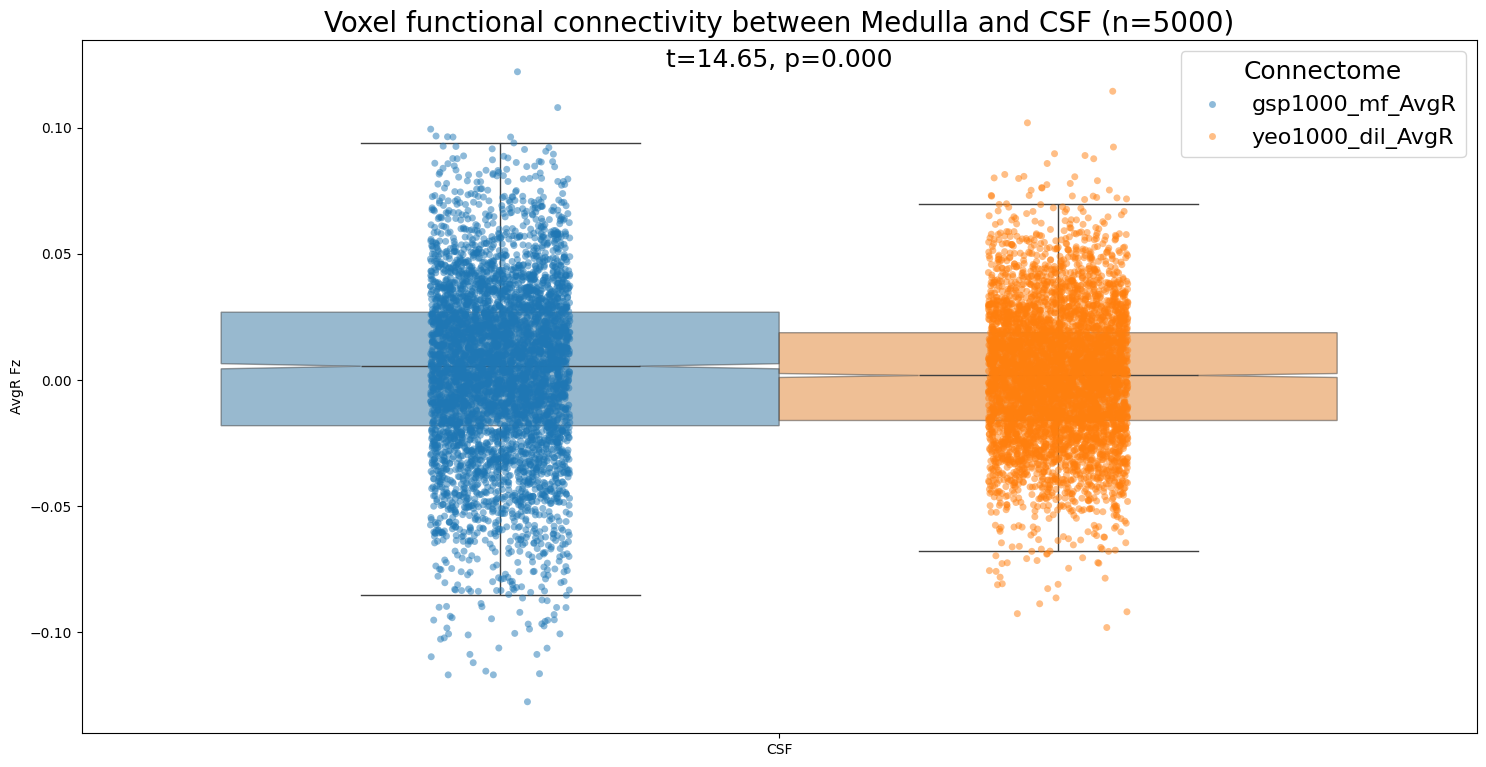

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('csvs/medulla_lateral_ventricle_connectivity_global.csv')

# Melt the dataframe for plotting
df_melted = pd.melt(df, id_vars=['roi1', 'roi2', 'diff'],
                    value_vars=['gsp1000_mf_AvgR', 'yeo1000_dil_AvgR'],
                    var_name='connectome', value_name='AvgR')

plt.figure(figsize=(18, 9))
sns.stripplot(data=df_melted, x='roi2', y='AvgR', hue='connectome', dodge=True, jitter=True, alpha=0.5)
sns.boxplot(data=df_melted, x='roi2', y='AvgR', hue='connectome', dodge=True, 
            boxprops=dict(alpha=0.5), showfliers=False, notch=True)

# Add the p-values to the plot at appropriate positions
# Get the y-position for the labels
y_max_ant = df_melted['AvgR'].max()
# y_max_post = df_melted[df_melted['roi2'] == 'posterior']['AvgR'].max()

plt.text(0, y_max_ant, f"t={t:.2f}, p={p:.3f}", ha='center', va='bottom', fontsize=18, color='black')
# plt.text(0.75, y_max_post, f"t={t_post:.2f}, p={p_post:.3f}", ha='center', va='bottom', fontsize=18, color='black')

plt.title('Voxel functional connectivity between Medulla and CSF (n=5000)', fontsize=20)
plt.xlabel('')
plt.xticks([0], ['CSF'])
plt.ylabel('AvgR Fz')
# For the legend, we don't need to show the legend for the stripplot, just the boxplot
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], title='Connectome', fontsize=16, title_fontsize=18)
plt.savefig('figures/medulla_csf_connectivity.png', transparent=True)
plt.show()


In [11]:
import os
import numpy as np
import pandas as pd
from nilearn import image
from nimlab.jax_functions import load_mask, load_image, NiftiMasker
from numpy.linalg import inv
from nilearn.image import resample_to_img, load_img

# Ensure we're in the correct directory
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')

path = 'csvs/medulla_csf_connectivity_global.csv'
df = pd.read_csv(path)
# Let's select the top 10 voxels with the highest difference in connectivity
top_10_diff = df.nsmallest(10, 'diff')
top_10_diff


roi1 roi2 voxel_idx_1 voxel_idx_2  gsp1000_mf_AvgR  yeo1000_dil_AvgR  \
2129  medulla  csf  [62 33  6]  [61 29  4]        -0.028063          0.239993   
4578  medulla  csf  [39 23 11]  [38 22  8]        -0.078428          0.176174   
2748  medulla  csf  [59 24  9]  [51 21  9]        -0.081317          0.107033   
3852  medulla  csf  [51 22 12]  [39 24  8]        -0.137578          0.046473   
4231  medulla  csf  [35 25  8]  [51 28  6]        -0.046372          0.126347   
772   medulla  csf  [63 29  8]  [65 28  5]         0.120590          0.278754   
228   medulla  csf  [32 21 12]  [36 24  6]        -0.099831          0.050111   
522   medulla  csf  [43 44 13]  [37 54 18]        -0.027863          0.120300   
4257  medulla  csf  [49 40  4]  [44 46  3]         0.238207          0.368155   
3568  medulla  csf  [32 25 11]  [29 20 13]         0.079433          0.207170   

          diff  
2129 -0.268056  
4578 -0.254602  
2748 -0.188349  
3852 -0.184051  
4231 -0.172719  
772  -0.158164  
228  -0.149942  
522  -0.148164  
4257 -0.129948  
3568 -0.127737